In [1]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [2]:
VERSION = 52
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 3
NO_BLACK_LOSS = True

In [3]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [4]:
all_black = '006d4432e'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [5]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
cols_le,cols_float,cols_bool = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_bool + cols_float

In [7]:
#meta_cols = ['ImagePositionPatient_1','pos_rel']

In [8]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [9]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [10]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [11]:
if DATA_SET == 1:
    dataset_name = 'Densenet161'
    feat_sz = 2208
elif DATA_SET == 2:
    dataset_name = 'Densenet169'
    feat_sz = 208
elif DATA_SET == 3:
    dataset_name = 'Densenet201'
    feat_sz = 240
else: assert False

In [12]:
if (DATA_SET == 2) or (DATA_SET == 3):
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/{}_v3/train/train.ids.df'.format(dataset_name),'wb'))

        #test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])
        
        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')
        
        assert len(test_md.SeriesInstanceUID.unique()) == 2214
        
        pickle.dump(test_md, open(PATH_WORK/'features/{}_v3/test/test.ids.df'.format(dataset_name),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}_3_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(dataset_name, fold)
            feats = pickle.load(open(filename,'rb'))
            assert len(feats) == 4*len(ids_df)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}_v3/train/train.f{}.a{}'
                                             .format(dataset_name,fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}_v3/train/valid.f{}.a{}'
                                             .format(dataset_name,fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/{}_v3/train/black.f{}'
                                                  .format(dataset_name,fold),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}_3_version_classifier_splits_type_features_test_split_{}.pkl'\
                .format(dataset_name,fold)
            feats = pickle.load(open(filename,'rb'))

            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/{}_v3/test/test.f{}.a{}'
                                            .format(dataset_name,fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/{}_v3/train/train.ids.df'.format(dataset_name),'rb'))
        test_md = pickle.load(open(PATH_WORK/'features/{}_v3/test/test.ids.df'.format(dataset_name),'rb'))

In [13]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [14]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [15]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [16]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset >= 2:
            path = PATH_WORK/'features/{}_v3/train/black.f{}'.format(dataset_name, fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
            
            if mode == 'valid':
                self.setFeats(0)
            
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        def getAPath(an):
            return PATH_WORK/'features/{}_v3/{}/{}.f{}.a{}'.format(dataset_name,folder,self.mode,self.fold,an)
        
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        sz = len(self.metadata)
        if anum == -1:
            max_a = 8 if self.mode == 'test' else 4
            feats2 = torch.stack([pickle.load(open(getAPath(an),'rb')) for an in range(max_a)])
            feats = feats2[torch.randint(max_a,(sz,)), torch.arange(sz)].squeeze()
        else:
            feats = pickle.load(open(getAPath(anum),'rb'))
        
        self.feats = feats
        assert len(feats) == sz
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset >= 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx1.values)
        df = df.sort_values(['pos_idx1'])
        feats = feats[torch.LongTensor(order)]
        
        non_black = torch.ones(len(feats))
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        feats_le = torch.LongTensor(df[cols_le].values)
        
        target = torch.Tensor(df[all_ich].values)
        
        PAD = 4+9+1
        #PAD = 3
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            feats_le = torch.cat([torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(top_pad,1), feats_le])
            if offset > 0:
                non_black = torch.cat([torch.zeros(offset), non_black])
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            feats_le = torch.cat([feats_le, torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(bot_pad,1)])
            if (60 - len(df) - offset) > 0:
                non_black = torch.cat([non_black, torch.zeros(60 - len(df) - offset)])
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats_le.shape[0] == (60 + 2*PAD)
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        #feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, feats_le, target, non_black
        else:
            return feats, feats_le, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [17]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [18]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()

In [19]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [20]:
act_fun = nn.ReLU(inplace=True)

def conv_layer(ni, nf, ks=3, act=True):
    bn = nn.BatchNorm1d(nf)
    layers = [nn.Conv1d(ni, nf, ks), bn]
    if act: layers.append(act_fun)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        layers  = [conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, act=False)]
        self.convs = nn.Sequential(*layers)

    def forward(self, x): return act_fun(self.convs(x) + x[:,:,1:-1])

In [21]:
class ResNetModel(nn.Module):
    def __init__(self, n_cont:int, feat_sz=2208):
        super().__init__()
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        
        self.conv2D = nn.Conv2d(1,64,(feat_sz + n_cont,1))
        
        self.res1 = ResBlock(64,64)
        self.res2 = ResBlock(64,64)
        self.res3 = ResBlock(64,64)
        
        self.conv1D = nn.Conv1d(64,6,1)
    
    def forward(self, x) -> torch.Tensor:
        x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        
        x = self.conv2D(x).squeeze()
        x = act_fun(x)
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        
        x = self.conv1D(x)
        x = x.transpose(1,2)
        return x

In [22]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        #self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([nn.Embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])
        
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,1))
        self.conv2D_2 = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,5))
        self.bn_cont1 = nn.BatchNorm1d(128)
        self.conv1D_1 = nn.Conv1d(128,64,3)
        self.conv1D_3 = nn.Conv1d(128,64,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(128,6,3)
        self.bn_cont2 = nn.BatchNorm1d(128)
        self.bn_cont3 = nn.BatchNorm1d(6)

        self.conv1D_4 = nn.Conv1d(128,128,3)
        self.bn_cont4 = nn.BatchNorm1d(128)

    def forward(self, x, x_le) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1) # bs,2208,60
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = self.fc_drop(x)
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        #x = self.conv1D_1(x)
        
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]), 
                       self.conv1D_3(x)], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        
        x = self.conv1D_4(x)
        x = self.relu(x)
        x = self.bn_cont4(x)
        
        x = self.conv1D_2(x)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [23]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    for i, (x, x_le, y, non_black) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
            y = y.to(device)
            non_black = non_black.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x, x_le)
        
        if MIXUP:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, lambd*non_black[:,:,None]) \
                     + criterion(output, y_mix, (1-lambd)*non_black[:,:,None])
            else:
                loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd)
            del x_mix, y_mix
        else:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, non_black[:,:,None])
            else:
                loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x, x_le
    
    return tloss, tloss_count

In [24]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, x_le, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [25]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [26]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET >= 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    #model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()

    if DATA_SMALL:
        #val_sz = int(0.01*len(loc_data.index.unique()))
        val_sz = len(val_ds)
        val_series = val_ds.series[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        #trn_ds.setFeats((i-1) % 4)
        trn_ds.setFeats(-1)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k]+1e-15, eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, auc, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [27]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [28]:
# 7x0.00002 more
# ver 51, epoch 28, fold 0, train ll: 0.0293, val ll: 0.0649, cor: 0.8417, auc: 0.9868, lr: 2e-05
# ver 51, epoch 32, fold 1, train ll: 0.0298, val ll: 0.0646, cor: 0.8379, auc: 0.9868, lr: 2e-05
# ver 51, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0621, cor: 0.8411, auc: 0.9882, lr: 2e-05


# 7x0.002, 7x0.001, 7x0.0002
# new metadata
# ver 51, epoch 21, fold 0, train ll: 0.0299, val ll: 0.0651, cor: 0.8411, auc: 0.9869, lr: 0.0002
# ver 51, epoch 21, fold 1, train ll: 0.0302, val ll: 0.0647, cor: 0.8374, auc: 0.9874, lr: 0.0002
# ver 51, epoch 21, fold 2, train ll: 0.0302, val ll: 0.0625, cor: 0.8400, auc: 0.9881, lr: 0.0002

# same for all meta
# ver 50, epoch 27, fold 0, train ll: 0.0293, val ll: nan, cor: 0.8411, auc: 0.9855, lr: 5e-06

# 2x5e-06
# ver 49, epoch 27, fold 0, train ll: 0.0293, val ll: 0.0647, cor: 0.8417, auc: 0.9870, lr: 5e-06
# 2x0.00002, 2x0.00001
# ver 49, epoch 25, fold 0, train ll: 0.0295, val ll: 0.0648, cor: 0.8416, auc: 0.9871, lr: 1e-05
# 7x0.002, 7x0.001, 7x0.0002
# reduced to 2 meta cols
# ver 49, epoch 21, fold 0, train ll: 0.0300, val ll: 0.0656, cor: 0.8404, auc: 0.9858, lr: 0.0002

# 3x0.002, 3x0.001, 3x0.0002
# back to orig
# ver 48, epoch 9,  fold 0, train ll: 0.0300, val ll: 0.0677, cor: 0.8405, auc: 0.9839, lr: 0.0002
# ver 48, epoch 14, fold 0, train ll: 0.0297, val ll: 0.0688, cor: 0.8391, auc: 0.9837, lr: 0.0002

# resnet
# 3x0.002, 3x0.001, 3x0.0002
# ver 47, epoch 9, fold 0, train ll: 0.0299, val ll: 0.0677, cor: 0.8359, auc: 0.9857, lr: 0.0002

# relu and bn switched places
# ver 44, epoch 21, fold 0, train ll: 0.0326, val ll: 0.0667, cor: 0.8361, auc: 0.9867, lr: 0.0002
# all doubled size
# ver 43, epoch 21, fold 0, train ll: 0.0313, val ll: 0.0656, cor: 0.8403, auc: 0.9858, lr: 0.0002
# +layer
# ver 42, epoch 21, fold 0, train ll: 0.0315, val ll: 0.0654, cor: 0.8403, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 7x0.0002
# ver 41, epoch 21, fold 2, train ll: 0.0321, val ll: 0.0630, cor: 0.8400, auc: 0.9878, lr: 0.0002
# ver 41, epoch 21, fold 1, train ll: 0.0317, val ll: 0.0652, cor: 0.8370, auc: 0.9863, lr: 0.0002
# ver 41, epoch 21, fold 0, train ll: 0.0310, val ll: 0.0654, cor: 0.8407, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 3x0.0002
# mixing aug
# ver 41, epoch 17, fold 0, train ll: 0.0308, val ll: 0.0657, cor: 0.8406, auc: 0.9862, lr: 0.0002
# no bn for feats
# ver 40, epoch 14, fold 0, train ll: 0.0315, val ll: 0.0663, cor: 0.8400, auc: 0.9859, lr: 0.0002

# mixup
# ver 39, epoch 21, fold 1, train ll: 0.0496, val ll: 0.0688, cor: 0.8318, auc: 0.9859, lr: 0.0002

# no dropout
# ver 39, epoch 14, fold 1, train ll: 0.0335, val ll: 0.0663, cor: 0.8335, auc: 0.9852, lr: 0.0002
# ver 39, epoch 17, fold 0, train ll: 0.0322, val ll: 0.0680, cor: 0.8369, auc: 0.9843, lr: 0.0002
# bs=32, no black
# ver 39, epoch 14, fold 0, train ll: 0.0354, val ll: 0.0689, cor: 0.8351, auc: 0.9830, lr: 0.0002

# bs=16
# ver 38, epoch 14, fold 0, train ll: 0.0365, val ll: 0.0694, cor: 0.8330, lr: 0.0002
# ver 38, epoch 17, fold 0, train ll: 0.0362, val ll: 0.0684, cor: 0.8346, lr: 0.0001

# back to 64, dropped dilated
# ver 37, epoch 14, fold 2, train ll: 0.0367, val ll: 0.0641, cor: 0.8360, lr: 0.0002
# ver 37, epoch 14, fold 1, train ll: 0.0374, val ll: 0.0665, cor: 0.8324, lr: 0.0002
# ver 37, epoch 14, fold 0, train ll: 0.0360, val ll: 0.0676, cor: 0.8346, lr: 0.0002

# 3x0.0001
# ver 36, epoch 17, fold 2, train ll: 0.0364, val ll: 0.0646, cor: 0.8367
# ver 36, epoch 16, fold 1, train ll: 0.0375, val ll: 0.0663, cor: 0.8326
# ver 36, epoch 17, fold 0, train ll: 0.0358, val ll: 0.0677, cor: 0.8357

# 7x0.02, 4x0.002, 3x0.0002
# bs = 32
# ver 36, epoch 14, fold 2, train ll: 0.0366, val ll: 0.0647, cor: 0.8362
# ver 36, epoch 13, fold 1, train ll: 0.0379, val ll: 0.0663, cor: 0.8327
# ver 36, epoch 14, fold 0, train ll: 0.0359, val ll: 0.0674, cor: 0.8354

# 10x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 34, epoch 19, train ll: 0.0363, val ll: 0.0675, cor: 0.8347

#--- dataset 2

# 13x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 32, epoch 22, train ll: 0.0375, val ll: 0.0582, cor: 0.8480

#--- dataset 1

# 10x0.02, 8x0.002, 3x0.0002
# with augmentations
# ver 31, epoch 21, train ll: 0.0866, val ll: 0.1533, cor: 0.5319

# 10x0.02, 6x0.002, 3x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# ver 26, epoch 19, train ll: 0.0867, val ll: 0.1531, cor: 0.5305

#--- dataset 2

# 10x0.02, 3x0.002, 6x0.0002 (+10x0.0002)
# back to orig best
# epoch 19, train ll: 0.0389, val ll: 0.0602, cor: 0.8424
# epoch 29, train ll: 0.0378, val ll: 0.0593, cor: 0.8448

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# reduced all sizes
# epoch 17, train ll: 0.0407, val ll: 0.0620, cor: 0.8371

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# epoch 17, train ll: 0.0379, val ll: 0.0589, cor: 0.8460

# 3x0.1, 5x0.02, 3x0.002, 6x0.0002
# dilated, 3xTTA
# epoch 17, train ll: 0.0364, val ll: 0.0582, cor: 0.8454, LB 0.066

# train ll: 0.0354, val ll: 0.0577, cor: 0.8462, LB 0.065

In [29]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# normalize metadata outliers
# try GCP fast guide connecting
# 32 TTA
# no auc

# Yuval: zoom in, squish, perspective wraping

In [30]:
DATA_SMALL = False
weight_decay = 1e-3
f = 0
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 3 train size 13042 fold 0
adding dummy serieses 168
DataSet 3 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 14.316 time per batch: 3.579
Batch 8 device: xla:1 time passed: 15.089 time per batch: 1.886
Batch 12 device: xla:1 time passed: 15.631 time per batch: 1.303
Batch 16 device: xla:1 time passed: 16.194 time per batch: 1.012
Batch 20 device: xla:1 time passed: 17.627 time per batch: 0.881
Batch 24 device: xla:1 time passed: 20.851 time per batch: 0.869
Batch 28 device: xla:1 time passed: 24.043 time per batch: 0.859
Batch 32 device: xla:1 time passed: 27.339 time per batch: 0.854
Batch 36 device: xla:1 time passed: 30.613 time per batch: 0.850
Batch 40 device: xla:1 time passed: 33.939 time per batch: 0.848
Batch 44 device: xla:1 time passed: 37.172 time per batch: 0.845
Batch 48 device: xla:1 

Batch 20 device: xla:1 time passed: 17.467 time per batch: 0.873
Batch 24 device: xla:1 time passed: 20.764 time per batch: 0.865
Batch 28 device: xla:1 time passed: 23.915 time per batch: 0.854
Batch 32 device: xla:1 time passed: 27.313 time per batch: 0.854
Batch 36 device: xla:1 time passed: 30.500 time per batch: 0.847
Batch 40 device: xla:1 time passed: 33.707 time per batch: 0.843
Batch 44 device: xla:1 time passed: 36.979 time per batch: 0.840
Batch 48 device: xla:1 time passed: 40.307 time per batch: 0.840
Batch 4 device: xla:1 time passed: 3.372 time per batch: 0.843
Batch 8 device: xla:1 time passed: 5.186 time per batch: 0.648
Batch 12 device: xla:1 time passed: 7.033 time per batch: 0.586
Batch 16 device: xla:1 time passed: 8.833 time per batch: 0.552
Batch 20 device: xla:1 time passed: 10.826 time per batch: 0.541
Batch 24 device: xla:1 time passed: 12.780 time per batch: 0.532
ver 52, epoch 7, fold 0, train ll: 0.0333, val ll: 0.0711, cor: 0.8255, auc: 0.9841, lr: 0.002
t

Batch 36 device: xla:1 time passed: 30.911 time per batch: 0.859
Batch 40 device: xla:1 time passed: 34.171 time per batch: 0.854
Batch 44 device: xla:1 time passed: 37.549 time per batch: 0.853
Batch 48 device: xla:1 time passed: 40.824 time per batch: 0.851
Batch 4 device: xla:1 time passed: 3.457 time per batch: 0.864
Batch 8 device: xla:1 time passed: 5.030 time per batch: 0.629
Batch 12 device: xla:1 time passed: 7.205 time per batch: 0.600
Batch 16 device: xla:1 time passed: 9.173 time per batch: 0.573
Batch 20 device: xla:1 time passed: 10.897 time per batch: 0.545
Batch 24 device: xla:1 time passed: 12.857 time per batch: 0.536
ver 52, epoch 13, fold 0, train ll: 0.0320, val ll: 0.0681, cor: 0.8333, auc: 0.9857, lr: 0.001
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.719 time per batch: 1.180
Batch 8 device: xla:1 time passed: 7.698 time per batch: 0.962
Batch 12 device: xla:1 time passed: 10.974 time per batch: 0.915
Batch 16 device: xla:1 time passed: 14.223 

Batch 4 device: xla:1 time passed: 3.544 time per batch: 0.886
Batch 8 device: xla:1 time passed: 5.081 time per batch: 0.635
Batch 12 device: xla:1 time passed: 6.925 time per batch: 0.577
Batch 16 device: xla:1 time passed: 8.862 time per batch: 0.554
Batch 20 device: xla:1 time passed: 10.869 time per batch: 0.543
Batch 24 device: xla:1 time passed: 12.809 time per batch: 0.534
ver 52, epoch 19, fold 0, train ll: 0.0305, val ll: 0.0651, cor: 0.8409, auc: 0.9867, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.069 time per batch: 1.267
Batch 8 device: xla:1 time passed: 7.871 time per batch: 0.984
Batch 12 device: xla:1 time passed: 11.170 time per batch: 0.931
Batch 16 device: xla:1 time passed: 14.363 time per batch: 0.898
Batch 20 device: xla:1 time passed: 17.632 time per batch: 0.882
Batch 24 device: xla:1 time passed: 20.864 time per batch: 0.869
Batch 28 device: xla:1 time passed: 24.097 time per batch: 0.861
Batch 32 device: xla:1 time passed: 27.303

In [31]:
DATA_SMALL = False
weight_decay = 1e-3
f = 1
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 3 train size 12982 fold 1
adding dummy serieses 108
DataSet 3 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.191 time per batch: 1.298
Batch 8 device: xla:1 time passed: 8.128 time per batch: 1.016
Batch 12 device: xla:1 time passed: 11.610 time per batch: 0.967
Batch 16 device: xla:1 time passed: 15.043 time per batch: 0.940
Batch 20 device: xla:1 time passed: 18.509 time per batch: 0.925
Batch 24 device: xla:1 time passed: 22.025 time per batch: 0.918
Batch 28 device: xla:1 time passed: 25.464 time per batch: 0.909
Batch 32 device: xla:1 time passed: 28.824 time per batch: 0.901
Batch 36 device: xla:1 time passed: 32.164 time per batch: 0.893
Batch 40 device: xla:1 time passed: 35.553 time per batch: 0.889
Batch 44 device: xla:1 time passed: 38.904 time per batch: 0.884
Batch 48 device: xla:1 ti

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 52, epoch 6, fold 1, train ll: 0.0352, val ll: nan, cor: 0.8233, auc: 0.9843, lr: 0.002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.932 time per batch: 1.233
Batch 8 device: xla:1 time passed: 7.759 time per batch: 0.970
Batch 12 device: xla:1 time passed: 10.993 time per batch: 0.916
Batch 16 device: xla:1 time passed: 14.255 time per batch: 0.891
Batch 20 device: xla:1 time passed: 17.510 time per batch: 0.875
Batch 24 device: xla:1 time passed: 20.759 time per batch: 0.865
Batch 28 device: xla:1 time passed: 24.058 time per batch: 0.859
Batch 32 device: xla:1 time passed: 27.318 time per batch: 0.854
Batch 36 device: xla:1 time passed: 30.541 time per batch: 0.848
Batch 40 device: xla:1 time passed: 33.877 time per batch: 0.847
Batch 44 device: xla:1 time passed: 37.098 time per batch: 0.843
Batch 48 device: xla:1 time passed: 40.253 time per batch: 0.839
Batch 4 device: xla:1 time passed: 3.520 time per batch: 0.880
Batch 8 device: xla:1 time passed: 5.057 ti

Batch 12 device: xla:1 time passed: 11.010 time per batch: 0.918
Batch 16 device: xla:1 time passed: 14.157 time per batch: 0.885
Batch 20 device: xla:1 time passed: 17.433 time per batch: 0.872
Batch 24 device: xla:1 time passed: 20.689 time per batch: 0.862
Batch 28 device: xla:1 time passed: 23.979 time per batch: 0.856
Batch 32 device: xla:1 time passed: 27.220 time per batch: 0.851
Batch 36 device: xla:1 time passed: 30.523 time per batch: 0.848
Batch 40 device: xla:1 time passed: 33.721 time per batch: 0.843
Batch 44 device: xla:1 time passed: 36.979 time per batch: 0.840
Batch 48 device: xla:1 time passed: 40.136 time per batch: 0.836
Batch 4 device: xla:1 time passed: 3.497 time per batch: 0.874
Batch 8 device: xla:1 time passed: 5.107 time per batch: 0.638
Batch 12 device: xla:1 time passed: 7.065 time per batch: 0.589
Batch 16 device: xla:1 time passed: 9.011 time per batch: 0.563
Batch 20 device: xla:1 time passed: 11.093 time per batch: 0.555
Batch 24 device: xla:1 time pas

Batch 28 device: xla:1 time passed: 24.127 time per batch: 0.862
Batch 32 device: xla:1 time passed: 27.327 time per batch: 0.854
Batch 36 device: xla:1 time passed: 30.643 time per batch: 0.851
Batch 40 device: xla:1 time passed: 34.208 time per batch: 0.855
Batch 44 device: xla:1 time passed: 37.493 time per batch: 0.852
Batch 48 device: xla:1 time passed: 40.762 time per batch: 0.849
Batch 4 device: xla:1 time passed: 3.589 time per batch: 0.897
Batch 8 device: xla:1 time passed: 5.092 time per batch: 0.636
Batch 12 device: xla:1 time passed: 7.051 time per batch: 0.588
Batch 16 device: xla:1 time passed: 9.225 time per batch: 0.577
Batch 20 device: xla:1 time passed: 11.123 time per batch: 0.556
Batch 24 device: xla:1 time passed: 13.050 time per batch: 0.544
ver 52, epoch 19, fold 1, train ll: 0.0303, val ll: 0.0642, cor: 0.8391, auc: 0.9871, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.919 time per batch: 1.230
Batch 8 device: xla:1 time passed: 7.707

In [32]:
DATA_SMALL = False
weight_decay = 1e-3
f = 2
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 3 train size 13036 fold 2
adding dummy serieses 162
DataSet 3 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.163 time per batch: 1.291
Batch 8 device: xla:1 time passed: 8.132 time per batch: 1.016
Batch 12 device: xla:1 time passed: 11.364 time per batch: 0.947
Batch 16 device: xla:1 time passed: 14.697 time per batch: 0.919
Batch 20 device: xla:1 time passed: 17.950 time per batch: 0.898
Batch 24 device: xla:1 time passed: 21.267 time per batch: 0.886
Batch 28 device: xla:1 time passed: 24.724 time per batch: 0.883
Batch 32 device: xla:1 time passed: 27.866 time per batch: 0.871
Batch 36 device: xla:1 time passed: 31.228 time per batch: 0.867
Batch 40 device: xla:1 time passed: 34.645 time per batch: 0.866
Batch 44 device: xla:1 time passed: 37.894 time per batch: 0.861
Batch 48 device: xla:1 ti

Batch 20 device: xla:1 time passed: 17.665 time per batch: 0.883
Batch 24 device: xla:1 time passed: 20.890 time per batch: 0.870
Batch 28 device: xla:1 time passed: 24.180 time per batch: 0.864
Batch 32 device: xla:1 time passed: 27.490 time per batch: 0.859
Batch 36 device: xla:1 time passed: 30.746 time per batch: 0.854
Batch 40 device: xla:1 time passed: 33.985 time per batch: 0.850
Batch 44 device: xla:1 time passed: 37.140 time per batch: 0.844
Batch 48 device: xla:1 time passed: 40.432 time per batch: 0.842
Batch 4 device: xla:1 time passed: 3.437 time per batch: 0.859
Batch 8 device: xla:1 time passed: 5.067 time per batch: 0.633
Batch 12 device: xla:1 time passed: 7.063 time per batch: 0.589
Batch 16 device: xla:1 time passed: 8.931 time per batch: 0.558
Batch 20 device: xla:1 time passed: 10.833 time per batch: 0.542
Batch 24 device: xla:1 time passed: 12.781 time per batch: 0.533
ver 52, epoch 7, fold 2, train ll: 0.0336, val ll: 0.0679, cor: 0.8315, auc: 0.9860, lr: 0.002
t

Batch 36 device: xla:1 time passed: 30.738 time per batch: 0.854
Batch 40 device: xla:1 time passed: 34.018 time per batch: 0.850
Batch 44 device: xla:1 time passed: 37.319 time per batch: 0.848
Batch 48 device: xla:1 time passed: 40.512 time per batch: 0.844
Batch 4 device: xla:1 time passed: 3.478 time per batch: 0.870
Batch 8 device: xla:1 time passed: 5.108 time per batch: 0.639
Batch 12 device: xla:1 time passed: 8.911 time per batch: 0.743
Batch 16 device: xla:1 time passed: 9.081 time per batch: 0.568
Batch 20 device: xla:1 time passed: 11.012 time per batch: 0.551
Batch 24 device: xla:1 time passed: 12.966 time per batch: 0.540
ver 52, epoch 13, fold 2, train ll: 0.0323, val ll: 0.0657, cor: 0.8351, auc: 0.9870, lr: 0.001
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.936 time per batch: 1.234
Batch 8 device: xla:1 time passed: 7.766 time per batch: 0.971
Batch 12 device: xla:1 time passed: 11.102 time per batch: 0.925
Batch 16 device: xla:1 time passed: 14.452 

Batch 4 device: xla:1 time passed: 3.639 time per batch: 0.910
Batch 8 device: xla:1 time passed: 5.161 time per batch: 0.645
Batch 12 device: xla:1 time passed: 7.043 time per batch: 0.587
Batch 16 device: xla:1 time passed: 9.064 time per batch: 0.566
Batch 20 device: xla:1 time passed: 11.017 time per batch: 0.551
Batch 24 device: xla:1 time passed: 12.971 time per batch: 0.540
ver 52, epoch 19, fold 2, train ll: 0.0305, val ll: 0.0622, cor: 0.8409, auc: 0.9884, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.928 time per batch: 1.232
Batch 8 device: xla:1 time passed: 7.738 time per batch: 0.967
Batch 12 device: xla:1 time passed: 11.028 time per batch: 0.919
Batch 16 device: xla:1 time passed: 14.272 time per batch: 0.892
Batch 20 device: xla:1 time passed: 17.509 time per batch: 0.875
Batch 24 device: xla:1 time passed: 20.798 time per batch: 0.867
Batch 28 device: xla:1 time passed: 24.064 time per batch: 0.859
Batch 32 device: xla:1 time passed: 27.327

In [33]:
learning_rate = 0.00002
f = 0
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 21 starting now: 7
DataSet 3 train size 13042 fold 0
adding dummy serieses 168
DataSet 3 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
loading model model.b21.f0.v52
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.173 time per batch: 1.293
Batch 8 device: xla:1 time passed: 8.465 time per batch: 1.058
Batch 12 device: xla:1 time passed: 11.734 time per batch: 0.978
Batch 16 device: xla:1 time passed: 14.946 time per batch: 0.934
Batch 20 device: xla:1 time passed: 18.257 time per batch: 0.913
Batch 24 device: xla:1 time passed: 21.600 time per batch: 0.900
Batch 28 device: xla:1 time passed: 24.860 time per batch: 0.888
Batch 32 device: xla:1 time passed: 28.159 time per batch: 0.880
Batch 36 device: xla:1 time passed: 31.456 time per batch: 0.874
Batch 40 device: xla:1 time passed: 34.726 time per batch: 0.868
Batch 44 device: xla:1 time passed: 38.048 time per batch: 0.865
Batch 48 device

Batch 20 device: xla:1 time passed: 17.775 time per batch: 0.889
Batch 24 device: xla:1 time passed: 21.168 time per batch: 0.882
Batch 28 device: xla:1 time passed: 24.373 time per batch: 0.870
Batch 32 device: xla:1 time passed: 27.614 time per batch: 0.863
Batch 36 device: xla:1 time passed: 30.965 time per batch: 0.860
Batch 40 device: xla:1 time passed: 34.251 time per batch: 0.856
Batch 44 device: xla:1 time passed: 37.603 time per batch: 0.855
Batch 48 device: xla:1 time passed: 40.837 time per batch: 0.851
Batch 4 device: xla:1 time passed: 3.533 time per batch: 0.883
Batch 8 device: xla:1 time passed: 5.014 time per batch: 0.627
Batch 12 device: xla:1 time passed: 6.988 time per batch: 0.582
Batch 16 device: xla:1 time passed: 8.964 time per batch: 0.560
Batch 20 device: xla:1 time passed: 10.901 time per batch: 0.545
Batch 24 device: xla:1 time passed: 12.840 time per batch: 0.535
ver 52, epoch 28, fold 0, train ll: 0.0297, val ll: 0.0646, cor: 0.8422, auc: 0.9868, lr: 2e-05


In [34]:
learning_rate = 0.00002
f = 1
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 21 starting now: 7
DataSet 3 train size 12982 fold 1
adding dummy serieses 108
DataSet 3 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
loading model model.b21.f1.v52
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.048 time per batch: 1.262
Batch 8 device: xla:1 time passed: 7.945 time per batch: 0.993
Batch 12 device: xla:1 time passed: 11.207 time per batch: 0.934
Batch 16 device: xla:1 time passed: 14.455 time per batch: 0.903
Batch 20 device: xla:1 time passed: 17.751 time per batch: 0.888
Batch 24 device: xla:1 time passed: 21.009 time per batch: 0.875
Batch 28 device: xla:1 time passed: 24.218 time per batch: 0.865
Batch 32 device: xla:1 time passed: 27.568 time per batch: 0.861
Batch 36 device: xla:1 time passed: 30.808 time per batch: 0.856
Batch 40 device: xla:1 time passed: 34.058 time per batch: 0.851
Batch 44 device: xla:1 time passed: 37.387 time per batch: 0.850
Batch 48 device

Batch 20 device: xla:1 time passed: 17.541 time per batch: 0.877
Batch 24 device: xla:1 time passed: 20.755 time per batch: 0.865
Batch 28 device: xla:1 time passed: 24.078 time per batch: 0.860
Batch 32 device: xla:1 time passed: 27.386 time per batch: 0.856
Batch 36 device: xla:1 time passed: 30.709 time per batch: 0.853
Batch 40 device: xla:1 time passed: 33.865 time per batch: 0.847
Batch 44 device: xla:1 time passed: 37.184 time per batch: 0.845
Batch 48 device: xla:1 time passed: 40.402 time per batch: 0.842
Batch 4 device: xla:1 time passed: 3.386 time per batch: 0.847
Batch 8 device: xla:1 time passed: 5.019 time per batch: 0.627
Batch 12 device: xla:1 time passed: 6.959 time per batch: 0.580
Batch 16 device: xla:1 time passed: 8.956 time per batch: 0.560
Batch 20 device: xla:1 time passed: 10.891 time per batch: 0.545
Batch 24 device: xla:1 time passed: 12.810 time per batch: 0.534
ver 52, epoch 28, fold 1, train ll: 0.0297, val ll: 0.0638, cor: 0.8395, auc: 0.9871, lr: 2e-05


In [35]:
learning_rate = 0.00002
f = 2
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 21 starting now: 7
DataSet 3 train size 13036 fold 2
adding dummy serieses 162
DataSet 3 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
loading model model.b21.f2.v52
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.235 time per batch: 1.309
Batch 8 device: xla:1 time passed: 8.266 time per batch: 1.033
Batch 12 device: xla:1 time passed: 11.503 time per batch: 0.959
Batch 16 device: xla:1 time passed: 14.760 time per batch: 0.922
Batch 20 device: xla:1 time passed: 18.038 time per batch: 0.902
Batch 24 device: xla:1 time passed: 21.231 time per batch: 0.885
Batch 28 device: xla:1 time passed: 24.456 time per batch: 0.873
Batch 32 device: xla:1 time passed: 27.745 time per batch: 0.867
Batch 36 device: xla:1 time passed: 30.981 time per batch: 0.861
Batch 40 device: xla:1 time passed: 34.318 time per batch: 0.858
Batch 44 device: xla:1 time passed: 37.508 time per batch: 0.852
Batch 48 device

Batch 20 device: xla:1 time passed: 17.743 time per batch: 0.887
Batch 24 device: xla:1 time passed: 21.113 time per batch: 0.880
Batch 28 device: xla:1 time passed: 24.310 time per batch: 0.868
Batch 32 device: xla:1 time passed: 27.568 time per batch: 0.862
Batch 36 device: xla:1 time passed: 30.803 time per batch: 0.856
Batch 40 device: xla:1 time passed: 33.999 time per batch: 0.850
Batch 44 device: xla:1 time passed: 37.187 time per batch: 0.845
Batch 48 device: xla:1 time passed: 40.311 time per batch: 0.840
Batch 4 device: xla:1 time passed: 3.498 time per batch: 0.874
Batch 8 device: xla:1 time passed: 5.105 time per batch: 0.638
Batch 12 device: xla:1 time passed: 6.971 time per batch: 0.581
Batch 16 device: xla:1 time passed: 8.991 time per batch: 0.562
Batch 20 device: xla:1 time passed: 10.938 time per batch: 0.547
Batch 24 device: xla:1 time passed: 12.857 time per batch: 0.536
ver 52, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0622, cor: 0.8407, auc: 0.9883, lr: 2e-05


In [36]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.056110,0.070803,0.828730,0.109298,0.022598,0.049880,0.032002,0.073406,0.099138,13042,6656,32,47.070485,15.420762,0.00200,0.001
1,2,0,0.035309,0.072277,0.832754,0.110532,0.023238,0.054608,0.036449,0.076983,0.093598,13042,6656,32,47.032977,14.305657,0.00200,0.001
2,3,0,0.034092,0.069362,0.836473,0.107782,0.020229,0.051002,0.033657,0.075275,0.089806,13042,6656,32,46.882269,14.352048,0.00200,0.001
3,4,0,0.040886,0.067295,0.837617,0.105520,0.019163,0.050104,0.031765,0.071146,0.087851,13042,6656,32,47.233110,14.336787,0.00200,0.001
4,5,0,0.035184,0.067748,0.838309,0.104713,0.020646,0.049876,0.032077,0.074214,0.087995,13042,6656,32,46.916375,14.293321,0.00200,0.001
5,6,0,0.034125,0.071849,0.834254,0.109937,0.021771,0.051256,0.036154,0.078188,0.095702,13042,6656,32,47.492861,14.435367,0.00200,0.001
6,7,0,0.033273,0.071098,0.825473,0.106233,0.020016,0.052940,0.040823,0.081493,0.089949,13042,6656,32,46.885059,14.260652,0.00200,0.001
7,8,0,0.032167,0.068228,0.836288,0.107479,0.019060,0.048676,0.031824,0.073577,0.089499,13042,6656,32,46.984614,14.274117,0.00100,0.001
8,9,0,0.031748,0.065881,0.839499,0.103297,0.018607,0.047965,0.030873,0.070798,0.086330,13042,6656,32,48.786881,14.370167,0.00100,0.001
9,10,0,0.033010,0.065751,0.840180,0.102547,0.019397,0.048774,0.030859,0.070335,0.085798,13042,6656,32,47.128286,14.352733,0.00100,0.001


In [43]:
predictions.shape

(6548, 60, 6)

In [49]:
predictions.mean((0,1))

array([0.33750427, 0.26280636, 0.27833307, 0.28676933, 0.30175668,
       0.30931562], dtype=float32)

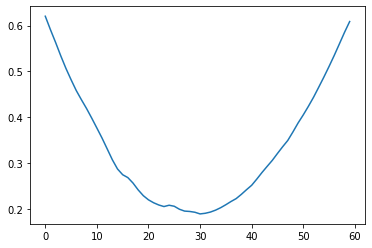

In [50]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [37]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + add_seed)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(anum)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [32]:
VERSION = 36

In [43]:
DATA_SMALL = False

In [38]:
preds = []
for fold in range(3):
    preds2 = []
    for anum in range(32):
        predictions = inference_one(fold = fold, anum = -1)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)

completed epochs: 28
loading model model.b28.f0.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 10.249388217926025
completed epochs: 28
loading model model.b28.f0.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.9405694007873535
completed epochs: 28
loading model model.b28.f0.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.66157341003418
completed epochs: 28
loading model model.b28.f0.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.453778982162476
completed epochs: 28
loading model model.b28.f0.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, 

test processing time: 6.245520830154419
completed epochs: 28
loading model model.b28.f1.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.3030335903167725
completed epochs: 28
loading model model.b28.f1.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.249770879745483
completed epochs: 28
loading model model.b28.f1.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.366688251495361
completed epochs: 28
loading model model.b28.f1.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.307455062866211
completed epochs: 28
loading model model.b28.f1.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 1
datas

test processing time: 6.342058420181274
completed epochs: 28
loading model model.b28.f2.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.516719341278076
completed epochs: 28
loading model model.b28.f2.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.249170541763306
completed epochs: 28
loading model model.b28.f2.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.228357553482056
completed epochs: 28
loading model model.b28.f2.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.197564363479614
completed epochs: 28
loading model model.b28.f2.v52
adding dummy serieses 186
DataSet 3 test size 2400 fold 2
datase

In [39]:
pickle.dump(preds, open(PATH_WORK/'preds_{}_v{}'.format(dataset_name, VERSION),'wb'))

In [49]:
VERSION

52

In [51]:
preds = 0.5* (pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 51),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 52),'rb')))

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [52]:
predictions = preds.mean((0,1))

In [53]:
predictions.mean(0)

array([0.12818354, 0.00708593, 0.04323302, 0.031913  , 0.04646458,
       0.05511025], dtype=float32)

In [57]:
predictions.mean(0)

array([0.1280228 , 0.00678272, 0.04317398, 0.03195811, 0.04593468,
       0.05528003], dtype=float32)

In [54]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [43]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1283438503742218

In [58]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1281835436820984

In [44]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [45]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [60]:
sub.to_csv(PATH/'sub.csv', index=False)

In [61]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9926577676746361

In [62]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f ~/sub.csv -m "TPU, new meta, 201+169, 4aug, 32TTA, 3folds, mean"

100%|██████████████████████████████████████| 16.6M/16.6M [00:04<00:00, 4.29MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection